In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure graphs display inline in the notebook
%matplotlib inline

# Configuration
CSV_PATH = 'weather.csv'
COL_TEMP = 'temperature_2m_mean (°C)'
COL_ET0 = 'et0_fao_evapotranspiration (mm)'

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
print("--- Loading Data ---")
try:
    df = pd.read_csv(CSV_PATH)
    # Convert time to datetime objects
    df['time'] = pd.to_datetime(df['time'])
    # Set time as index for easier resampling/plotting
    df.set_index('time', inplace=True)

    # Display the first few rows
    display(df[[COL_TEMP, COL_ET0]].head())
    print(f"Data Loaded. Total Rows: {len(df)}")

except FileNotFoundError:
    print("Error: CSV file not found. Please upload 'Algiers_Weather_Data.csv'.")

--- Loading Data ---


,temperature_2m_mean (°C),et0_fao_evapotranspiration (mm)
time,,
2002-01-01,12.2,1.27
2002-01-02,12.2,1.65
2002-01-03,12.0,1.87
2002-01-04,10.2,1.02
2002-01-05,10.6,1.18


Data Loaded. Total Rows: 7913


## Key Statistics

In [3]:
# Calculate basic stats
desc = df[[COL_TEMP, COL_ET0]].describe()

# Formatting for better readability
display(desc.style.background_gradient(cmap='Blues'))

,temperature_2m_mean (°C),et0_fao_evapotranspiration (mm)
count,7913.000000,7913.000000
mean,17.864893,3.724016
std,6.080578,1.817405
min,2.000000,0.300000
25%,12.700000,2.130000
50%,17.200000,3.530000
75%,23.300000,5.240000
max,36.700000,9.580000


## Anomalies and Extreme Events

In [14]:
def analyze_anomalies(column_name):
    series = df[column_name]
    mean = series.mean()
    std = series.std()

    lower_bound = mean - 2.5 * std
    upper_bound = mean + 2.5 * std

    outliers = df[(series < lower_bound) | (series > upper_bound)][column_name]

    print(f"--- Analysis for {column_name} ---")
    print(f"Thresholds: < {lower_bound:.2f} or > {upper_bound:.2f}")
    print(f"Count of Anomalies: {len(outliers)}")

    if len(outliers) > 0:
        print("\nTop 5 Highest Values (Anomalies):")
        display(outliers.sort_values(ascending=False).head(5))
        print("-" * 30)
    return outliers

# Run for Temp
temp_outliers = analyze_anomalies(COL_TEMP)

# Run for ET0
et0_outliers = analyze_anomalies(COL_ET0)

--- Analysis for temperature_2m_mean (°C) ---
Thresholds: < 2.66 or > 33.07
Count of Anomalies: 12

Top 5 Highest Values (Anomalies):


,temperature_2m_mean (°C)
time,
2023-07-11,36.7
2017-08-01,34.6
2023-07-18,34.4
2008-09-09,34.0
2023-07-23,33.8


------------------------------
--- Analysis for et0_fao_evapotranspiration (mm) ---
Thresholds: < -0.82 or > 8.27
Count of Anomalies: 37

Top 5 Highest Values (Anomalies):


,et0_fao_evapotranspiration (mm)
time,
2008-09-09,9.58
2015-07-01,9.41
2023-07-17,9.33
2009-06-14,9.29
2015-07-06,9.19


------------------------------


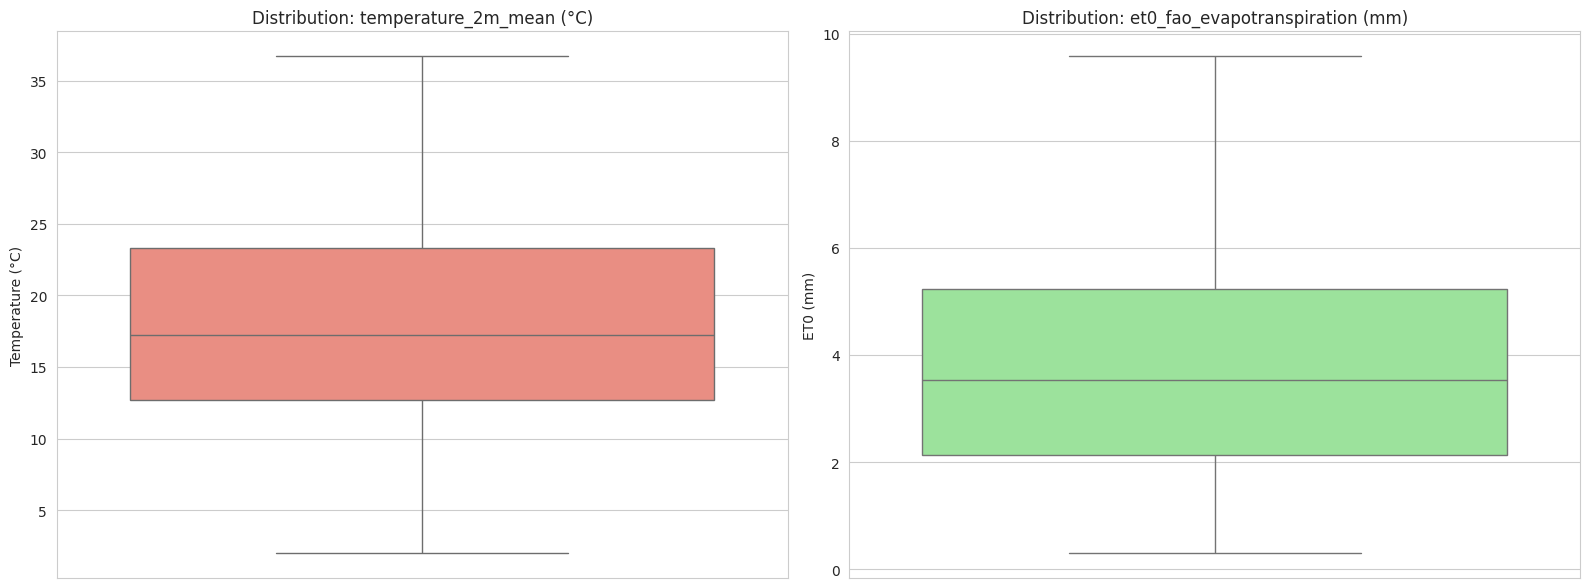

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(y=df[COL_TEMP], ax=ax1, color='salmon')
ax1.set_title(f'Distribution: {COL_TEMP}')
ax1.set_ylabel('Temperature (°C)')

sns.boxplot(y=df[COL_ET0], ax=ax2, color='lightgreen')
ax2.set_title(f'Distribution: {COL_ET0}')
ax2.set_ylabel('ET0 (mm)')

plt.tight_layout()
plt.show()

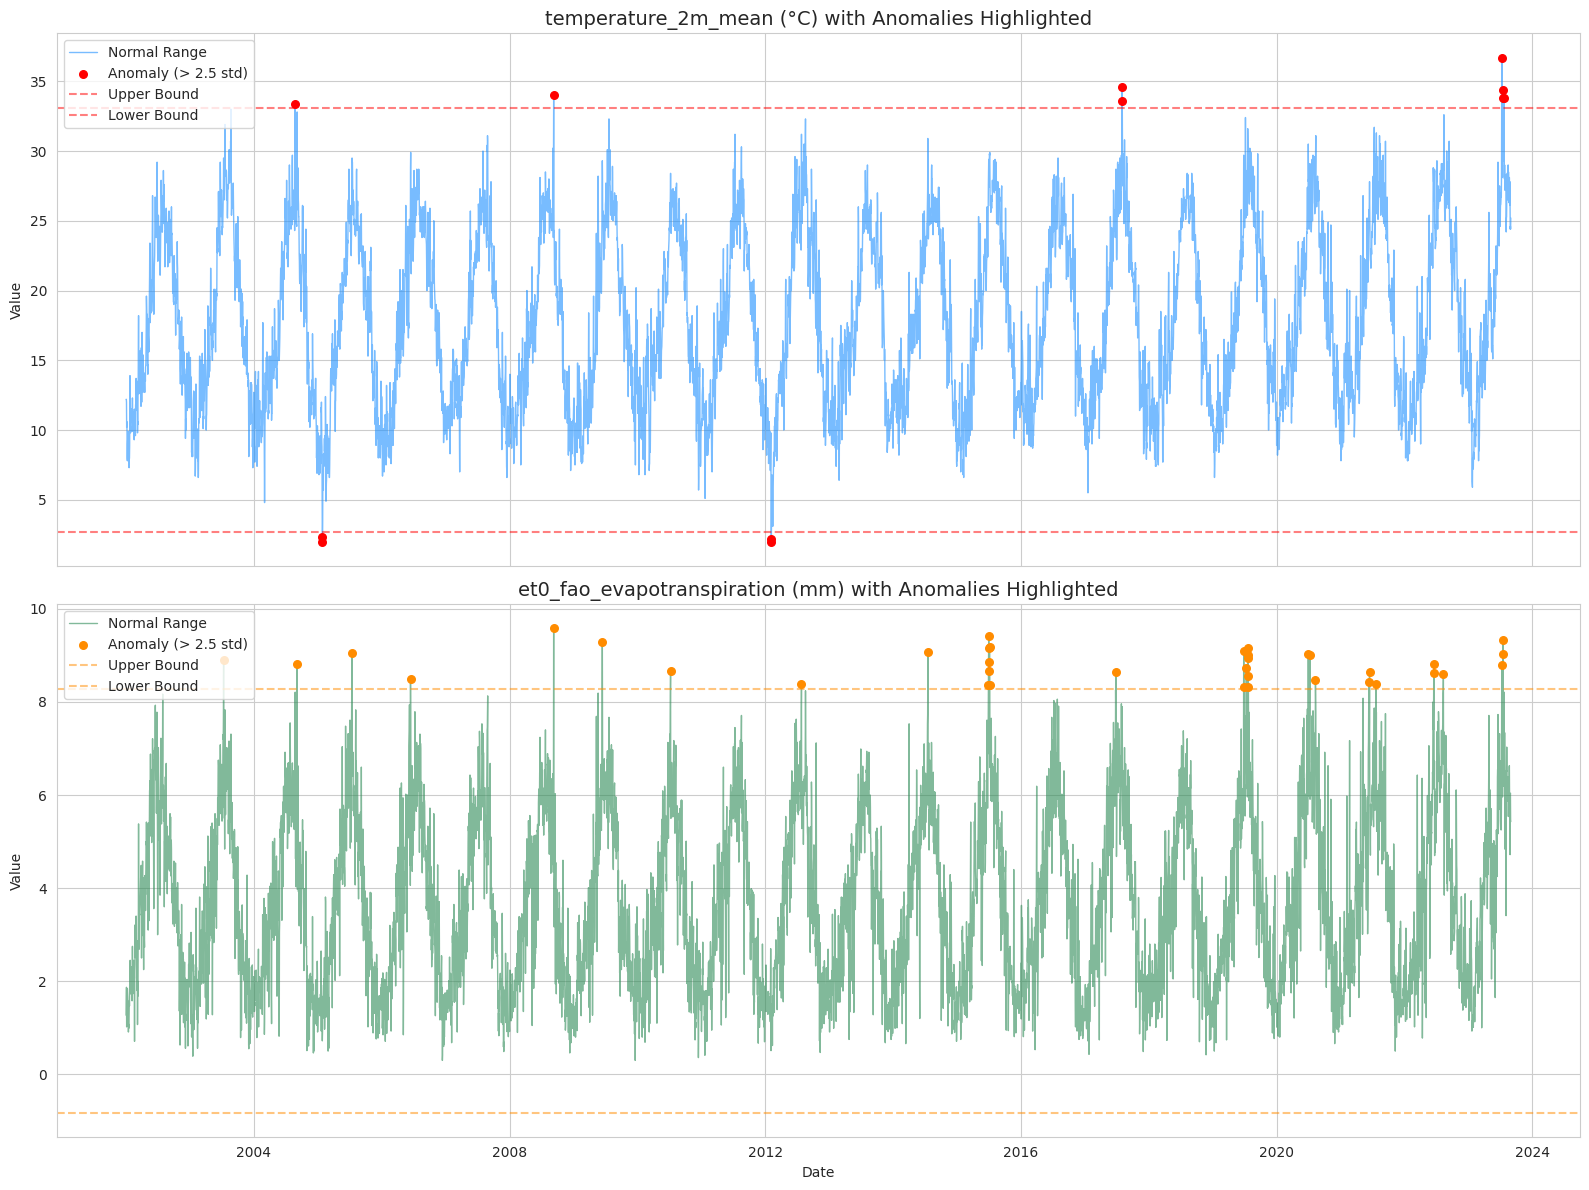

In [12]:
def plot_anomalies_time_series(df, col_name, ax, color_base, color_anomaly, threshold=2.5):
    """
    Plots the full time series and highlights points outside threshold*std.
    """
    # 1. Calculate Statistics
    series = df[col_name]
    mean = series.mean()
    std = series.std()

    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std

    # 2. Identify Anomalies
    anomalies = df[(series < lower_bound) | (series > upper_bound)][col_name]

    # 3. Plot Full Data (Background)
    ax.plot(df.index, series, color=color_base, alpha=0.6, label='Normal Range', linewidth=1)

    # 4. Plot Anomalies (Scatter points on top)
    ax.scatter(anomalies.index, anomalies, color=color_anomaly, s=30, label=f'Anomaly (> {threshold} std)', zorder=5)

    # 5. Add Threshold Lines
    ax.axhline(upper_bound, color=color_anomaly, linestyle='--', alpha=0.5, label='Upper Bound')
    ax.axhline(lower_bound, color=color_anomaly, linestyle='--', alpha=0.5, label='Lower Bound')

    # Formatting
    ax.set_title(f'{col_name} with Anomalies Highlighted', fontsize=14)
    ax.set_ylabel('Value')
    ax.legend(loc='upper left')

# --- Generate the Plot ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot Temperature
plot_anomalies_time_series(
    df,
    COL_TEMP,
    ax1,
    color_base='dodgerblue',
    color_anomaly='red',
    threshold=2.5
)

# Plot ET0
plot_anomalies_time_series(
    df,
    COL_ET0,
    ax2,
    color_base='seagreen',
    color_anomaly='darkorange',
    threshold=2.5
)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Long-Term Climate Trends (365-Day Moving Average)

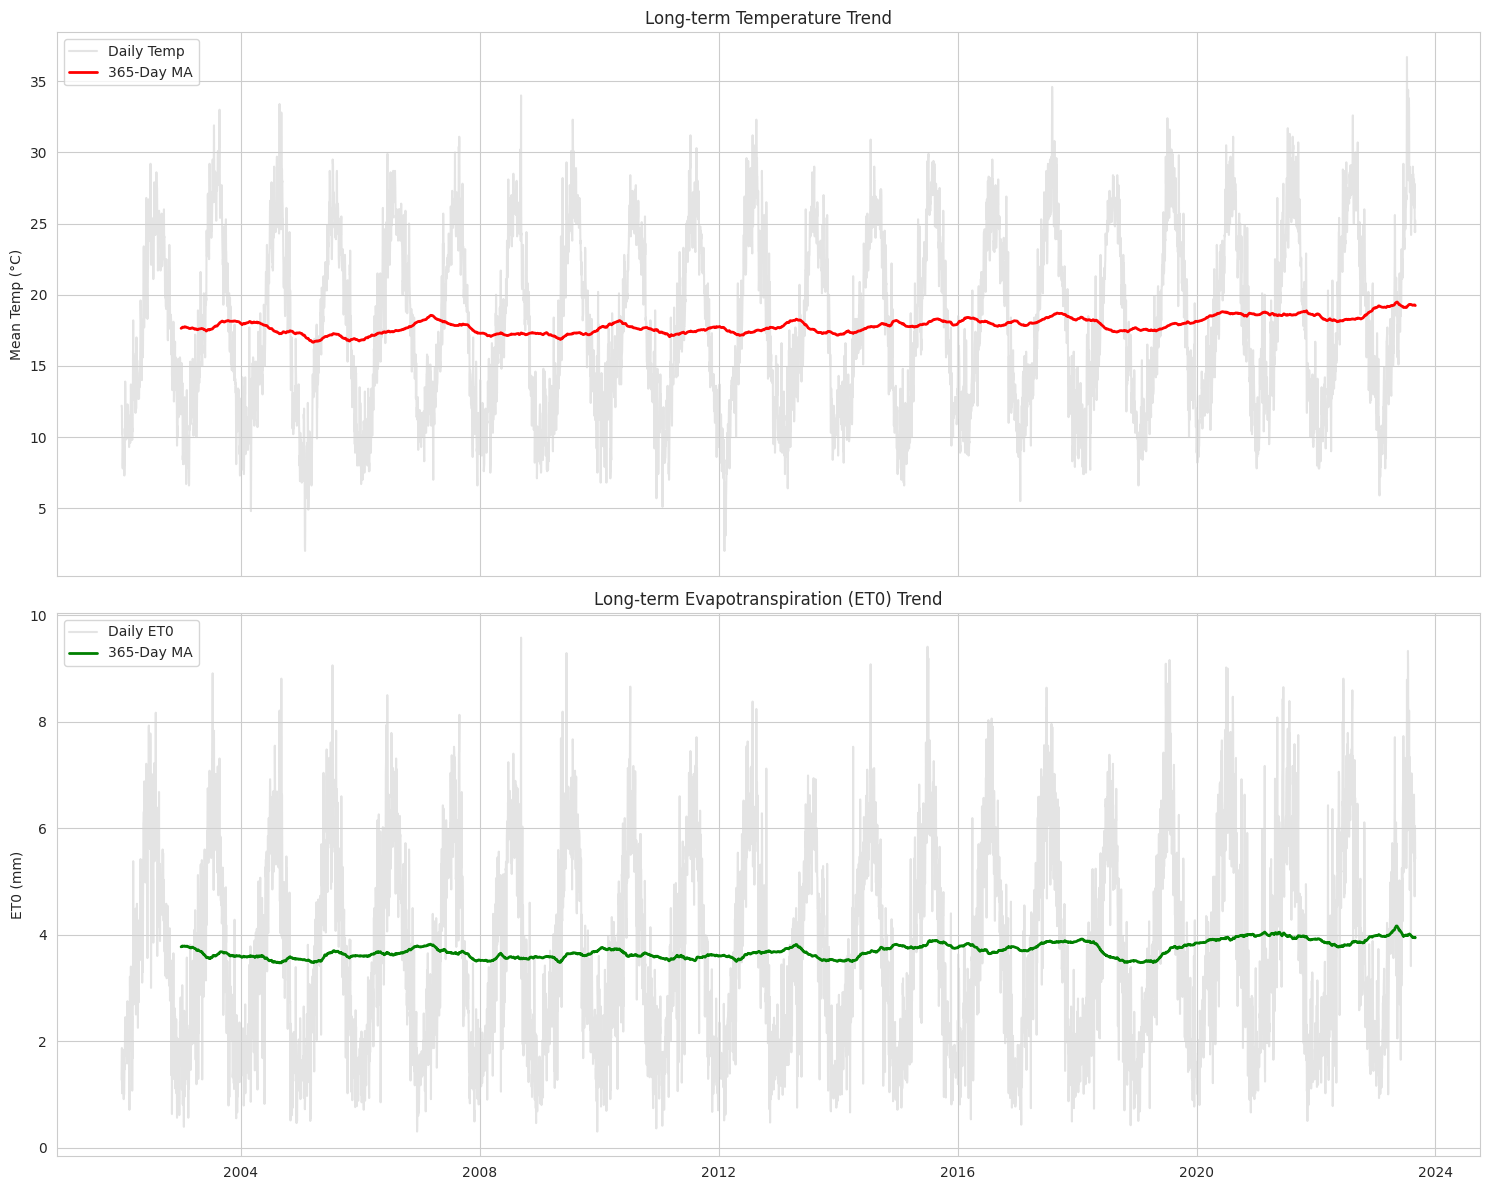

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot Temperature
ax1.plot(df.index, df[COL_TEMP], color='lightgray', alpha=0.6, label='Daily Temp')
ax1.plot(df[COL_TEMP].rolling(window=365).mean(), color='red', linewidth=2, label='365-Day MA')
ax1.set_ylabel('Mean Temp (°C)')
ax1.set_title('Long-term Temperature Trend')
ax1.legend(loc='upper left')

# Plot ET0
ax2.plot(df.index, df[COL_ET0], color='lightgray', alpha=0.6, label='Daily ET0')
ax2.plot(df[COL_ET0].rolling(window=365).mean(), color='green', linewidth=2, label='365-Day MA')
ax2.set_ylabel('ET0 (mm)')
ax2.set_title('Long-term Evapotranspiration (ET0) Trend')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Annual Climate Trends

Annual Averages:


/tmp/ipython-input-2613968241.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df[[COL_TEMP, COL_ET0]].resample('Y').mean()


,temperature_2m_mean (°C),et0_fao_evapotranspiration (mm),Year
time,,,
2019-12-31,18.134521,3.844685,2019
2020-12-31,18.561749,3.969372,2020
2021-12-31,18.606027,3.913973,2021
2022-12-31,19.072329,3.979644,2022
2023-12-31,18.865844,4.292716,2023


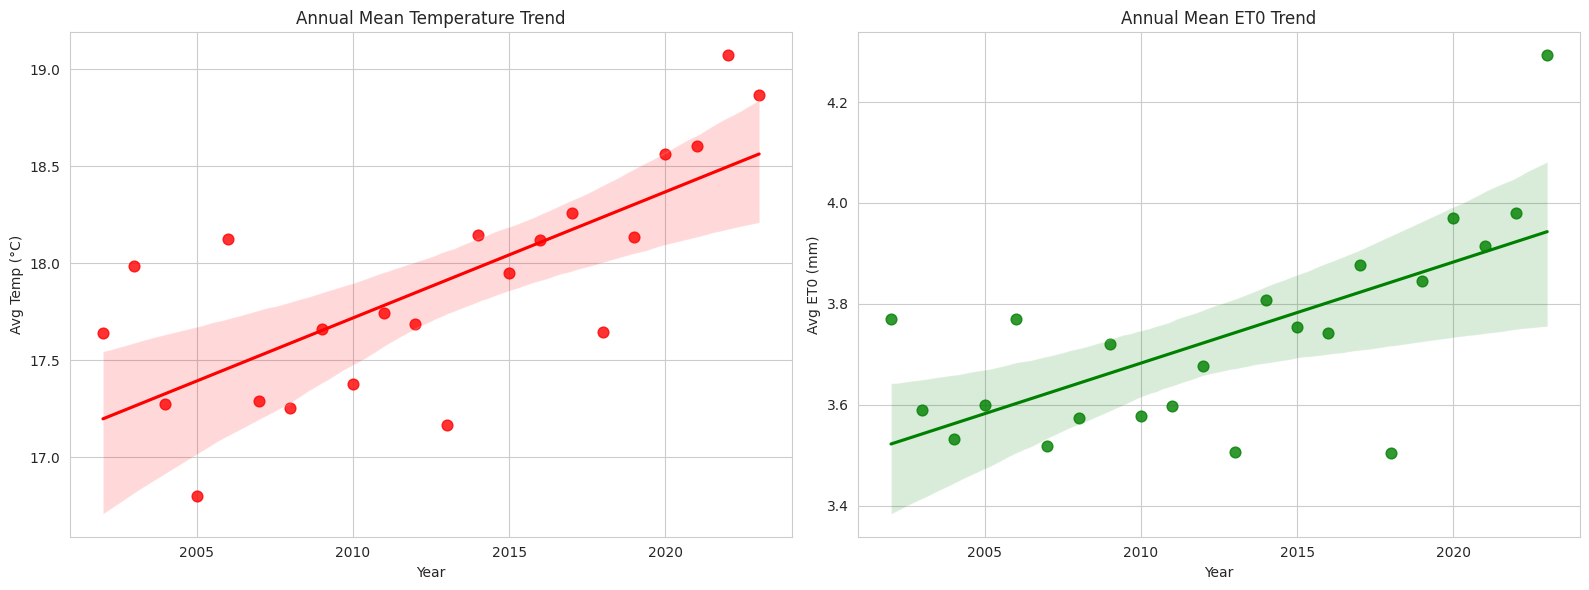

In [8]:
# Resample by Year ('Y') and take the mean
df_yearly = df[[COL_TEMP, COL_ET0]].resample('Y').mean()
df_yearly['Year'] = df_yearly.index.year

# Display Table
print("Annual Averages:")
display(df_yearly.tail())

# Plot Regplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Temp Trend
sns.regplot(x='Year', y=COL_TEMP, data=df_yearly, ax=ax1, color='red', scatter_kws={'s':60})
ax1.set_title('Annual Mean Temperature Trend')
ax1.set_ylabel('Avg Temp (°C)')

# ET0 Trend
sns.regplot(x='Year', y=COL_ET0, data=df_yearly, ax=ax2, color='green', scatter_kws={'s':60})
ax2.set_title('Annual Mean ET0 Trend')
ax2.set_ylabel('Avg ET0 (mm)')

plt.tight_layout()
plt.show()